<a href="https://colab.research.google.com/github/YongWanJin/KDTteam5_semiproject/blob/main/code/%EC%BD%94%EB%A1%9C%EB%82%98%EC%9D%B4%ED%9B%84_%EB%A7%A4%EC%B6%9C%EC%95%A1%ED%9A%8C%EB%B3%B5_%EC%8B%9C%EA%B0%81%ED%99%94(%EB%A6%AC%EB%89%B4%EC%96%BC%2C%20%EB%AF%B8%EC%99%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
from glob import glob      
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import folium
from IPython.display import display 

In [9]:
### 데이터 불러오기

# 1. 상권코드&추정매출액 (2017~2022Q1) 불러오기&병합 : sales
# 2022년 1분기까지 모두 포함

file_names = glob("/content/gdrive/MyDrive/datafile/추정매출(2017~2022Q1)/*.csv") 

sales = pd.DataFrame()    
for file_name in file_names : 
    temp = pd.read_csv(file_name, encoding='CP949')
    sales = pd.concat([sales, temp])               
del(temp)

sales.reset_index(inplace=True, drop=True)          

display(sales)

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2021,1,A,골목상권,2110001,이북5도청사,CS100001,한식음식점,626851391,25502,...,157,15667,7253,108,1098,2013,4344,7792,7568,28
1,2021,1,A,골목상권,2110001,이북5도청사,CS100008,분식전문점,122957138,12039,...,0,6679,4293,52,926,1222,2698,3404,2670,9
2,2021,1,A,골목상권,2110001,이북5도청사,CS100009,호프-간이주점,5093349,177,...,9,124,36,0,0,9,18,62,71,3
3,2021,1,A,골목상권,2110001,이북5도청사,CS100010,커피-음료,13507733,1359,...,8,356,881,0,243,260,213,288,235,5
4,2021,1,A,골목상권,2110001,이북5도청사,CS200001,일반교습학원,37551380,128,...,0,56,72,0,0,8,96,8,16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825955,2022,1,A,골목상권,2110001,이북5도청사,CS200001,일반교습학원,46710839,136,...,0,96,40,0,0,0,120,16,0,3
825956,2022,1,A,골목상권,2110001,이북5도청사,CS100010,커피-음료,20931521,2018,...,0,955,1009,0,382,342,380,581,279,2
825957,2022,1,A,골목상권,2110001,이북5도청사,CS100009,호프-간이주점,5119924,159,...,18,115,18,0,0,18,18,54,44,1
825958,2022,1,A,골목상권,2110001,이북5도청사,CS100008,분식전문점,92420017,10197,...,0,5872,3689,26,401,1191,2273,3093,2576,3


In [10]:
# 2. 상권코드&행정동코드&좌표값 불러오기 : location
location = pd.read_csv("/content/gdrive/MyDrive/datafile/상권영역_위도경도추가.csv")


# 3. 행정동코드&행정동이름 불러오기 : name
name = pd.read_csv("/content/gdrive/MyDrive/datafile/행정동코드-이름_매치파일.csv")

In [11]:
### sales 전처리 : sales 데이터에서 필요한 부분만 골라내기

# 분기 순서에 맞춰 필요한 연도 추출 : 2019년 3분기 ~ 2022년 1분기
sales = sales[ sales['기준_년_코드'] >= 2019  ] # 연도 추출
sales.drop( sales[(sales['기준_년_코드']==2019)&(sales['기준_분기_코드']<=2)].index, inplace=True) # 필요없는 분기 제거


# 필요한 업종만 추출 : 식당업
sales['서비스_업종_코드'] = sales['서비스_업종_코드'].str.replace(pat=r'[CS]',repl=r'', regex=True).astype('int')
sales = sales[ sales['서비스_업종_코드'] <= 100010]  

# 필요한 columns 골라내기
sales = sales[['기준_년_코드', '기준_분기_코드', '상권_코드', '분기당_매출_금액', '상권_구분_코드_명', '서비스_업종_코드_명']]

display(sales) # 결과

,기준_년_코드,기준_분기_코드,상권_코드,분기당_매출_금액,상권_구분_코드_명,서비스_업종_코드_명
0,2021,1,2110001,626851391,골목상권,한식음식점
1,2021,1,2110001,122957138,골목상권,분식전문점
2,2021,1,2110001,5093349,골목상권,호프-간이주점
3,2021,1,2110001,13507733,골목상권,커피-음료
12,2021,1,2110002,361894416,골목상권,한식음식점
...,...,...,...,...,...,...
825947,2022,1,2110002,346852071,골목상권,한식음식점
825956,2022,1,2110001,20931521,골목상권,커피-음료
825957,2022,1,2110001,5119924,골목상권,호프-간이주점
825958,2022,1,2110001,92420017,골목상권,분식전문점


In [12]:
### name의 상권코드와 location의 행정동코드 병합하기 (location에 병합)

# location 전처리 : 필요한 행만 골라내기
location = location[['상권_코드', '행정동_코드', '경도', '위도']]

# name 전처리 : location의 행정동코드와 자릿수를 같게 만들기
name['행정동코드'] = name['행정동코드']/100
name['행정동코드'] = name['행정동코드'].astype(int)

# name 전처리 : 필요한 열, 필요한 행만 골라내기
name = name[name['시도명']=='서울특별시']
name = name[['행정동코드', '시군구명', '읍면동명']]

# location과 name을 location에 join
location = pd.merge(location, name, left_on='행정동_코드', right_on='행정동코드')
location.drop('행정동_코드', axis='columns', inplace=True) # 중복되는 열 제거

display(location) # 결과

,상권_코드,경도,위도,행정동코드,시군구명,읍면동명
0,2110753,126.908844,37.448687,11545710,금천구,시흥제5동
1,2110748,126.904810,37.448765,11545710,금천구,시흥제5동
2,2110754,126.910150,37.452869,11545710,금천구,시흥제5동
3,2130238,126.910095,37.451617,11545710,금천구,시흥제5동
4,2110427,127.070978,37.634469,11350611,노원구,하계1동
...,...,...,...,...,...,...
3677,2130166,126.918620,37.594260,11380590,은평구,응암제2동
3678,2130113,127.094587,37.606387,11260690,중랑구,신내2동
3679,2130051,127.017283,37.562266,11140665,중구,동화동
3680,2130102,127.062547,37.604597,11230750,동대문구,이문제2동


In [13]:
### location과 sales 병합하기 (sales에 병합)
sales = pd.merge(sales, location, left_on = '상권_코드', right_on='상권_코드')
sales = sales[['기준_년_코드', '기준_분기_코드', '시군구명', '읍면동명', '분기당_매출_금액', '상권_구분_코드_명', '서비스_업종_코드_명', '경도', '위도']]

# 어디선가 꼬여버린 순서를 분기 순서에 맞게 재배치
temp1 = sales[sales['기준_년_코드']==2019].sort_values(by='기준_분기_코드')
for y in range(2020, 2023) :
    temp2 = sales[sales['기준_년_코드']==y].sort_values(by='기준_분기_코드')
    temp1 = pd.concat([temp1, temp2])
sales = temp1
del(temp1)
del(temp2)

display(sales) # 결과물

,기준_년_코드,기준_분기_코드,시군구명,읍면동명,분기당_매출_금액,상권_구분_코드_명,서비스_업종_코드_명,경도,위도
64,2019,3,종로구,평창동,617366771,골목상권,한식음식점,126.956884,37.609345
77952,2019,3,영등포구,양평제2동,1715934320,골목상권,한식음식점,126.892219,37.536260
77951,2019,3,영등포구,양평제2동,1715934320,골목상권,한식음식점,126.892219,37.536260
77950,2019,3,영등포구,양평제2동,1715934320,골목상권,한식음식점,126.892219,37.536260
130882,2019,3,중구,명동,2170985300,발달상권,양식음식점,126.977667,37.567626
...,...,...,...,...,...,...,...,...,...
75476,2022,1,금천구,독산제2동,58629176,골목상권,패스트푸드점,126.901897,37.463747
75475,2022,1,금천구,독산제2동,19662439,골목상권,치킨전문점,126.901897,37.463747
75474,2022,1,금천구,독산제2동,160504059,골목상권,분식전문점,126.901897,37.463747
75551,2022,1,금천구,시흥제1동,199970430,골목상권,분식전문점,126.902834,37.447169


In [14]:
### 연도와 분기를 구분해주는 라벨링 작업 : 추후 반복작업을 위해서
sales_time = sales[['기준_년_코드', '기준_분기_코드']].drop_duplicates()
sales_time['시점_구분_변수'] = [p for p in range(len(sales_time))]
sales = pd.merge(sales, sales_time)

In [15]:
### 구별 전분기 대비 매출액 증가율 집계

# 집계한 결과들을 기입하기 위한 변수 inc_gu 생성
# ex) 2019년4분기 : 2019년3분기 대비 2019년4분기의 매출액 증가율
index = [gu for gu in sales['시군구명'].unique()]
columns = ["2019년4분기", "2020년1분기", "2020년2분기", "2020년3분기", "2020년4분기",
           "2021년1분기", "2021년2분기", "2021년3분기", "2021년4분기", "2022년1분기"]
inc_gu = pd.DataFrame(index = index, columns = columns)  

# 증가율 집계
for p in range( len(sales['시점_구분_변수'].unique())-1 ) :

    means_before = sales[ sales['시점_구분_변수']==p ].groupby('시군구명')['분기당_매출_금액'].mean()
    means_before = np.array(means_before) # 구 단위로 전 분기 매출 평균 계산

    means_now = sales[ sales['시점_구분_변수']==p+1 ].groupby('시군구명')['분기당_매출_금액'].mean()
    means_now = np.array(means_now) # 구 단위로 이번 분기 매출 평균 계산

    inc = (means_now - means_before)/means_before*100 # 전분기 대비 이번 분기 매출 평균 증가율 계산
    inc = np.round(inc, 2).reshape(25,1)
    inc = inc.tolist()
    inc_gu.iloc[:,[p]] = inc # 입력

display(inc_gu) # 결과



,2019년4분기,2020년1분기,2020년2분기,2020년3분기,2020년4분기,2021년1분기,2021년2분기,2021년3분기,2021년4분기,2022년1분기
종로구,10.78,-18.52,4.96,-2.78,-7.45,-8.26,19.57,-14.81,29.28,-15.09
영등포구,11.18,-13.19,8.0,-8.38,-9.19,-9.08,13.08,-4.87,17.09,-13.25
중구,8.75,-14.27,13.39,-10.06,-14.18,-13.27,22.72,-5.93,12.27,-15.6
강동구,6.1,-15.67,4.85,-4.71,-9.92,-7.67,14.07,-8.87,14.6,-11.82
금천구,3.49,-14.19,5.15,-8.29,-12.27,-11.82,14.53,-7.1,21.4,-13.24
송파구,18.62,-21.56,4.17,-7.74,-8.87,-10.83,22.45,-10.53,20.37,-13.37
강북구,9.12,-15.37,6.6,-5.72,-6.53,-6.48,13.27,-14.6,20.29,-14.98
구로구,8.1,-13.67,9.2,-4.65,-5.82,-7.47,16.84,-10.83,20.44,-14.19
성북구,12.27,-15.06,8.04,-8.31,-9.91,-11.56,20.28,-6.77,12.09,-12.4
동작구,5.93,-10.1,9.77,-8.96,-8.71,-9.58,15.23,-3.09,9.52,-12.18


In [121]:
# 한글 글꼴 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

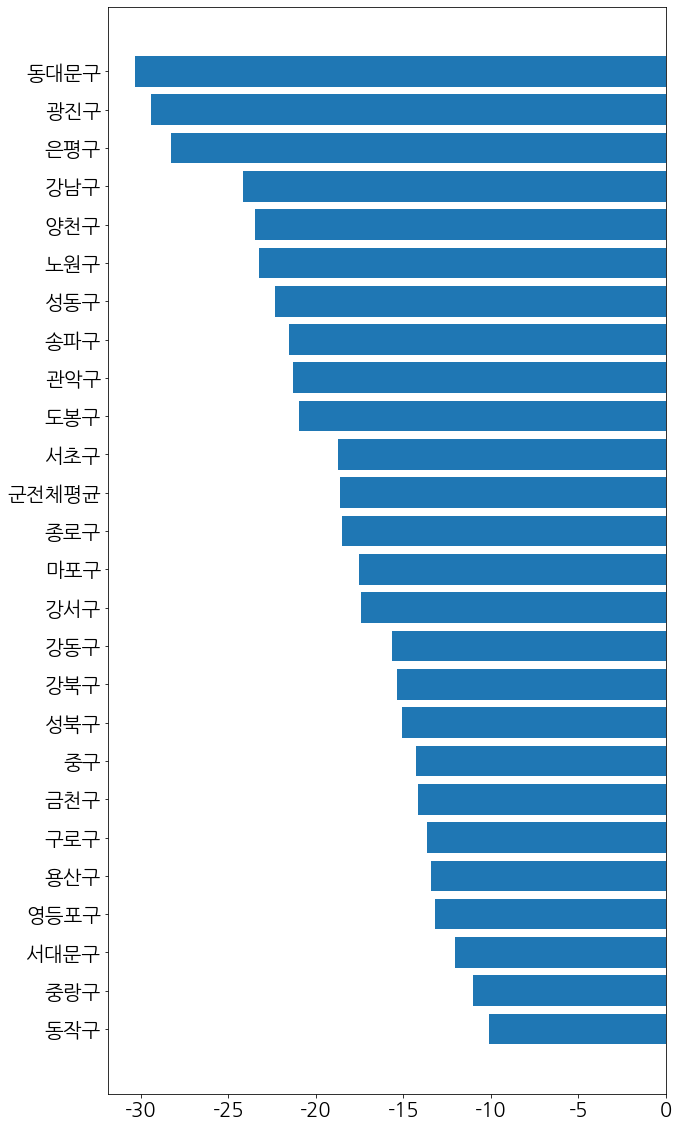

In [71]:
### 1-1. 코로나 직후(2020년 1분기)에 타격을 가장 많이 받은 구 순으로 막대그래프

# 막대그래프 그릴때 사용할 데이터프레임 inc_gu_2020q1 생성
inc_gu_2020q1 = pd.DataFrame()
inc_gu_2020q1['시군구명'] = inc_gu.index
inc_gu_2020q1['2020년1분기'] = inc_gu['2020년1분기'].values

inc_mean = inc_gu_2020q1['2020년1분기'].mean()
inc_mean_df = pd.DataFrame({'시군구명':['군전체평균'], '2020년1분기':[inc_mean]})
inc_gu_2020q1 = pd.concat([inc_gu_2020q1, inc_mean_df])

inc_gu_2020q1.sort_values(by='2020년1분기', ascending=False, inplace=True)


# 가로 막대그래프 생성

y = np.arange(len(inc_gu_2020q1))  # 세로축에 들어갈 값
values = inc_gu_2020q1['2020년1분기']   # 가로축에 들어갈 값

plt.barh(y, values)
plt.yticks(y, inc_gu_2020q1['시군구명'].values.tolist())


plt.rc('font', family='NanumGothic') # 한글 글꼴 설정
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

plt.rcParams["figure.figsize"] = [10,20] # 그래프 전체 크기
plt.rc('font', size=20)  # 글자 크기

# 군전체평균만 색깔 다르게지정

# 상위 5개는 좀더 튀는 색깔로

# x축 인덱스 맨 위로

# 막대그래프 왼쪽에 붙이기

# 제목 지정

plt.show()



In [126]:
### 1-2. 1-1의 결과를 지도시각화

seoul_map = "/content/gdrive/MyDrive/datafile/seoul-dong.geojson" # 서울 시군구별로 나눈 지도

center = [37.541, 126.986]
m = folium.Map(location=center, zoom_start=10)

folium.Choropleth(geo_data = seoul_map,
                  data = inc_gu_2020q1,
                  columns = ('시군구명', '2020년1분기'),
                  key_on = 'feature.properties.구',
                  fill_color='BuPu',
                  legend_name='코로나직후_매출증가율').add_to(m)
                          # 정보데이터와 지도 데이터 결합 => choropleth
m



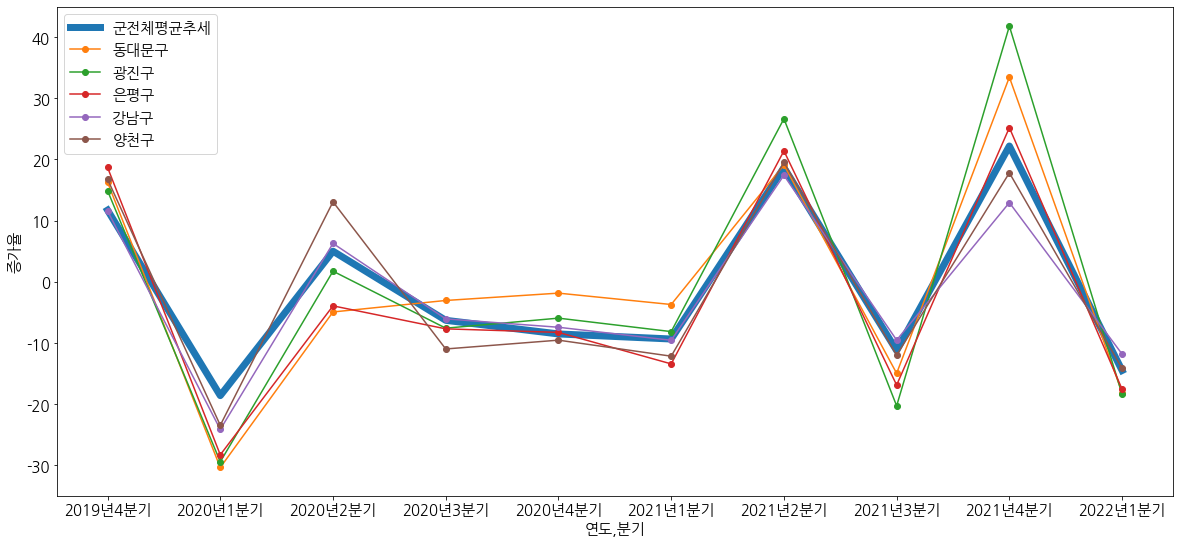

In [124]:
### 타격이 심했던 구들의 회복 추세? 

# 이번 시각화에 쓸 데이터프레임 inc_gu_trand1 생성
inc_gu_trand1 = inc_gu.sort_values(by='2020년1분기') # 코로나 직후 큰 타격을 받았던 곳 중심으로 재배치
trand_means = []   # 평균값 구하기
for i in range(10) :
    mean = inc_gu_trand1.iloc[:, [i]].mean().values[0]
    trand_means.append(mean)
inc_gu_trand1.loc[len(inc_gu_trand1)] = trand_means  # 평균값 추가
inc_gu_trand1.rename(index={25:'군전체평균추세'}, inplace=True)



x = np.arange(10)  # 가로축에 들어갈 값
values = inc_gu_trand1 # 세로축에 표기할 값
num = 5  # 그래프로 나타낼 데이터 개수

# 그래프 그리기
plt.plot(x, inc_gu_trand1.iloc[25], linewidth = '7.0') # 평균 추세, 
for i in range(num) :
    plt.plot(x, inc_gu_trand1.iloc[i], marker='o') # 코로나 직후 저조했던 군 하위5개


plt.xlabel('연도,분기') # x축 제목
plt.xticks(x, inc_gu_trand1.columns.to_list()) # 실제로 x축에 표기할 내용

plt.ylabel('증가율') # y축 제목

plt.ylim(-35, 45) # y축 표기범위

legend_list = ['군전체평균추세'] + [gu for gu in inc_gu_trand1.index.to_list()[:num]] # 범주
plt.legend(legend_list)

plt.rcParams["figure.figsize"] = [20,9] # 그래프 전체 크기
plt.rc('font', size=15)  # 글자 크기

plt.show() # 결과


### 결론 : 

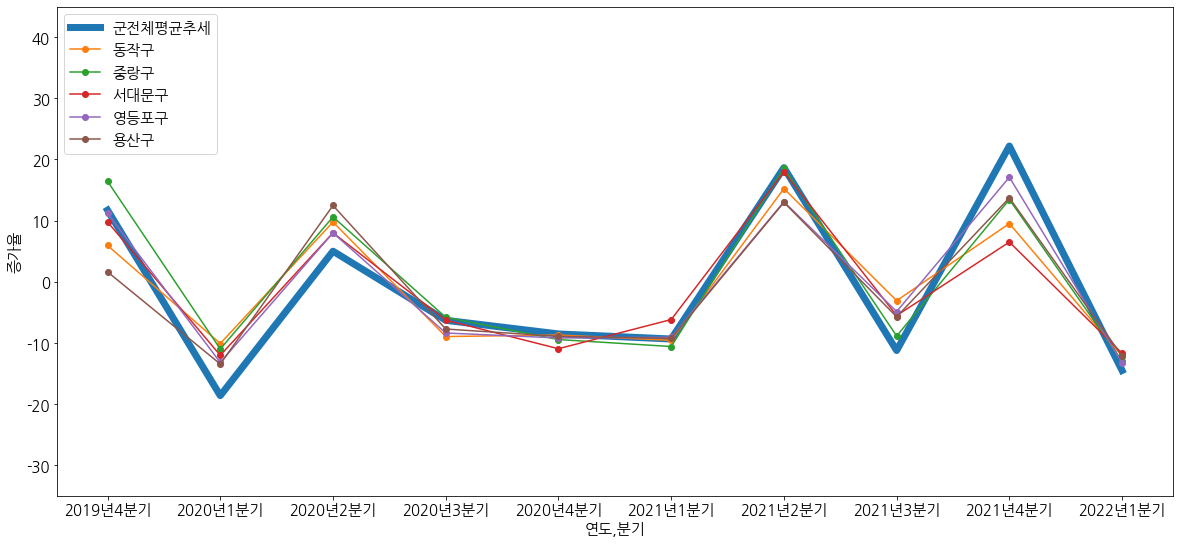

In [125]:
### 그렇다면 타격이 덜했던 구들의 회복 추세? 

# 이번 시각화에 쓸 데이터프레임 inc_gu_trand2 생성
inc_gu_trand2 = inc_gu.sort_values(by='2020년1분기', ascending=False) # 코로나 직후 비교적 적은 타격을 받았던 곳 중심으로 재배치
trand_means = []   # 평균값 구하기
for i in range(10) :
    mean = inc_gu_trand2.iloc[:, [i]].mean().values[0]
    trand_means.append(mean)
inc_gu_trand2.loc[len(inc_gu_trand2)] = trand_means  # 평균값 추가
inc_gu_trand2.rename(index={25:'군전체평균추세'}, inplace=True)



x = np.arange(10)  # 가로축에 들어갈 값
values = inc_gu_trand2 # 세로축에 표기할 값
num = 5  # 그래프로 나타낼 데이터 개수

# 그래프 그리기
plt.plot(x, inc_gu_trand2.iloc[25], linewidth = '7.0') # 평균 추세, 
for i in range(num) :
    plt.plot(x, inc_gu_trand2.iloc[i], marker='o') # 상위5개


plt.xlabel('연도,분기') # x축 제목
plt.xticks(x, inc_gu_trand2.columns.to_list()) # 실제로 x축에 표기할 내용

plt.ylabel('증가율') # y축 제목

plt.ylim(-35, 45) # y축 표기범위

legend_list = ['군전체평균추세'] + [gu for gu in inc_gu_trand2.index.to_list()[:num]] # 범주
plt.legend(legend_list)


plt.rcParams["figure.figsize"] = [20,9] # 그래프 전체 크기
plt.rc('font', size=15)  # 글자 크기

plt.show() # 결과


### 결론 : 

In [ ]:

plt.plot(x, inc_gu_trand1.iloc[24], linestyle = ":")